The following packages are required:
   - matplotlib
   - mpl_toolkits.basemap
   - netCDF4
   - numpy
   - pandas
   - pyreadr
   - rpy2
   - scipy

In [1]:
import sys
sys.path.insert(1, 'src')

import os
import matplotlib.pyplot as plt
from datetime import datetime
import netCDF4
import numpy as np
import pyreadr
import pandas as pd

ModuleNotFoundError: No module named 'pyreadr'

## Read Data

Read the wind speed residual $Y_t(\mathbf{s}^\ast)$ at 3,173 knots from 2013 to 2016 (Feb. 29 in the leap year 2016 is removed)

In [2]:
ncin = netCDF4.Dataset('./data/wind_residual.nc', 'r', format='NETCDF4')
wind_residual = ncin.variables['wind_residual'][:]
lon_knots = ncin.variables['lon'][:]
lat_knots = ncin.variables['lat'][:]
ncin.close()

## Set up the ESN

In [4]:
from model import ESN
from data import Data
from index import Index
from hyperpara import Hyperpara

In [5]:
hyperpara = Hyperpara()

The optimal values of ESN parameters:

                         input lag,      m = 1
        number of reservoir states,    n_h = 2500
                     ridge penalty, lambda = 0.15
    scaling matrix parameter for W,  delta = 0.9
                      leaking rate,    phi = 1.0
         magnitude of entries in W,    a_w = 0.05
         magnitude of entries in U,    a_u = 0.01
                     sparsity of W,   pi_w = 0.1
                     sparsity of U,   pi_u = 0.01


In [6]:
wind_residual.T.shape

(35040, 3173)

In [7]:
nTime = wind_residual.shape[1]
print('The total number of hours (2013-2016) considered:', nTime)

data = Data(nTime, wind_residual)
index = Index()

The total number of hours (2013-2016) considered: 35040


In [9]:
data.ts

(35040, 3173)

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_float("x", -100, 100)
    y = trial.suggest_categorical("y", [-1, 0, 1])
    return x**2 + y

if __name__ == "__main__":
    study = optuna.create_study(
        storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        study_name="quadratic-simple"
    )
    study.optimize(objective, n_trials=100)
    print(f"Best value: {study.best_value} (params: {study.best_params})")

In [8]:
import utils
import importlib
importlib.reload(utils)
A = np.array([1, 0, 0]).reshape(1, -1)
B = np.random.rand(3, 2 * 3)
C = utils.ts_product(A, B, 2, 3, 3)
print(C)

[[0.01857266 0.91653384 0.11780934 0.         0.         0.
  0.         0.         0.         0.74509687 0.36868128 0.52745196
  0.         0.         0.         0.         0.         0.        ]
 [0.23758629 0.21414725 0.50419283 0.         0.         0.
  0.         0.         0.         0.94973737 0.88286747 0.24997693
  0.         0.         0.         0.         0.         0.        ]
 [0.7497811  0.46639175 0.28245589 0.         0.         0.
  0.         0.         0.         0.89742074 0.92264781 0.20825867
  0.         0.         0.         0.         0.         0.        ]]


### Forecast wind speed residual for 2016

Set rerun = True to re-run the forecast, which uses 100 ensemble members and takes some time. Otherwise, the precomputed result is used

<span style="color:red"> Due to the storage limit in Github, the precomputed results cannot be uploaded. The variable rerun must be True for the first time. The forecast for the whole year 2016 should finish less than one hour.</span>

In [6]:
rerun = True

index.test_start = nTime - 365*24 # 2016-1-1 00:00
index.test_end = nTime - 1 # 2016-12-31 23:00 (inclusive)
esn_model = ESN(data, index)

if rerun:
    esn_model.train(hyperpara.parameter)
    print('ESN model trained with parameters: ', hyperpara.parameter)
    
    t0 = datetime.now()
    esn_model.forecast()
    t1 = datetime.now()

    print('Elapased time: ', t1 - t0)
    
    esn_model.compute_forecast_mean()

    for timeAhead in range(esn_model.numTimePred):
        df = pd.DataFrame(esn_model.forMean[:,:,timeAhead])
        pyreadr.write_rds("results/2016mean-{}hourAhead.RDS".format(timeAhead+1),df)
        
else:
    esn_model.outSampleEmb_index = np.arange(esn_model.index.test_start, esn_model.index.test_end+1)
    esn_model.forMean = np.ndarray((8760,3173,3))
    esn_model.forMean[:,:,0] = np.array(pyreadr.read_r('results/2016mean-1hourAhead.RDS')[None])
    esn_model.forMean[:,:,1] = np.array(pyreadr.read_r('results/2016mean-2hourAhead.RDS')[None])
    esn_model.forMean[:,:,2] = np.array(pyreadr.read_r('results/2016mean-3hourAhead.RDS')[None])
    esn_model.forMeanComputed = True

ESN model trained with parameters:  [1, 2500, 0.15, 0.9, 1.0, 0.05, 0.01, 0.1, 0.01]
Forecasting, ensemble: 1 2 Elapased time:  0:02:30.601616


## Calculate the MSE on knots for residuals

In [7]:
esn_mse = esn_model.compute_MSPE()

per_err = np.zeros_like(esn_model.forMean)

for i in range(esn_model.numTimePred):
    per_err[:,:,i] = data.ts[esn_model.outSampleEmb_index] - data.ts[esn_model.outSampleEmb_index - i - 1]
per_err[np.isnan(esn_model.forMean)] = np.nan

per_mse = np.nanmean(per_err**2,axis=(0,1))

In [8]:
print("Part of Table 3 for the MSE for y_t^* at all 3,173 knots \
and time points in 2016 by the ESN and persistence methods. \
Note that the ESN is a stochastic approach, \
so the MSE may be slightly different than the values reported in the paper.\n")

print("---------------------------------------------")
print("|     Forecast      |   ESN   | Persistence |")
print("---------------------------------------------")
print("|  One hour ahead   |  {:.3f}  |    {:.3f}    |".format(esn_mse[0],per_mse[0]))
print("|  Two hours ahead  |  {:.3f}  |    {:.3f}    |".format(esn_mse[1],per_mse[1]))
print("| Three hours ahead |  {:.3f}  |    {:.3f}    |".format(esn_mse[2],per_mse[2]))
print("---------------------------------------------")

Part of Table 3 for the MSE for y_t^* at all 3,173 knots and time points in 2016 by the ESN and persistence methods. Note that the ESN is a stochastic approach, so the MSE may be slightly different than the values reported in the paper.

---------------------------------------------
|     Forecast      |   ESN   | Persistence |
---------------------------------------------
|  One hour ahead   |  0.235  |    0.326    |
|  Two hours ahead  |  0.394  |    0.657    |
| Three hours ahead |  0.508  |    0.920    |
---------------------------------------------


In [8]:
print("Part of Table 3 for the MSE for y_t^* at all 3,173 knots \
and time points in 2016 by the ESN and persistence methods. \
Note that the ESN is a stochastic approach, \
so the MSE may be slightly different than the values reported in the paper.\n")

print("---------------------------------------------")
print("|     Forecast      |   ESN   | Persistence |")
print("---------------------------------------------")
print("|  One hour ahead   |  {:.3f}  |    {:.3f}    |".format(esn_mse[0],per_mse[0]))
print("|  Two hours ahead  |  {:.3f}  |    {:.3f}    |".format(esn_mse[1],per_mse[1]))
print("| Three hours ahead |  {:.3f}  |    {:.3f}    |".format(esn_mse[2],per_mse[2]))
print("---------------------------------------------")

Part of Table 3 for the MSE for y_t^* at all 3,173 knots and time points in 2016 by the ESN and persistence methods. Note that the ESN is a stochastic approach, so the MSE may be slightly different than the values reported in the paper.

---------------------------------------------
|     Forecast      |   ESN   | Persistence |
---------------------------------------------
|  One hour ahead   |  0.253  |    0.326    |
|  Two hours ahead  |  0.415  |    0.657    |
| Three hours ahead |  0.531  |    0.920    |
---------------------------------------------


# Forecast for all the 53333 locations

In [9]:
ncin = netCDF4.Dataset('./data/wind_residual_all_locations.nc', 'r', format='NETCDF4')
wind_residual_all_locations = ncin.variables['wind_residual_all_locations'][:]
lat_all_locations = ncin.variables['lat_all_locations'][:]
lon_all_locations = ncin.variables['lon_all_locations'][:]
ncin.close()

## Run the R script to get the spatial predictions. 
Precomputed result as follows are provided in ./spatial:
- NS_fit.Rdata, for the inferred nonstationary covariance model
- esn_mse_all_locations.npz, for the prediction MSE

In [10]:
rerun = False

if rerun:
    os.system("Rscript spatial/spatial_infer.R")
    
os.system("Rscript spatial/spatial_compile.R")

if rerun:
    os.system('Rscript spatial/get_all_krig_weight.R')
    krig_weight_all = pyreadr.read_r('spatial/all_krig_weight.RDS')
    krig_weight_all = np.array(krig_weight_all[None])
    krig_weight_all = krig_weight_all.reshape(53333, -1, order = 'F')

    forMean2016_all = krig_weight_all.dot(esn_model.forMean)

    forError2016_all = np.zeros_like(forMean2016_all)
    for ahead in range(esn_model.numTimePred):
        forError2016_all[:,:,ahead] = forMean2016_all[:,:,ahead] - \
            wind_residual_all_locations[:, esn_model.outSampleEmb_index]

    esn_mse_all_locations = np.nanmean(forError2016_all ** 2, axis = 1)
    np.savez(file = 'spatial/esn_mse_all_locations.npz', esn_mse_all_locations = esn_mse_all_locations)

else:
    df = np.load('spatial/esn_mse_all_locations.npz')
    esn_mse_all_locations = df['esn_mse_all_locations']
    df.close()

## Draw Figure 3, the nonstationary covariance model

src/utils.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  urcrnrlon=56.6,urcrnrlat=33.2)
src/utils.py:53: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m.drawcountries(linewidth=1, color="black")


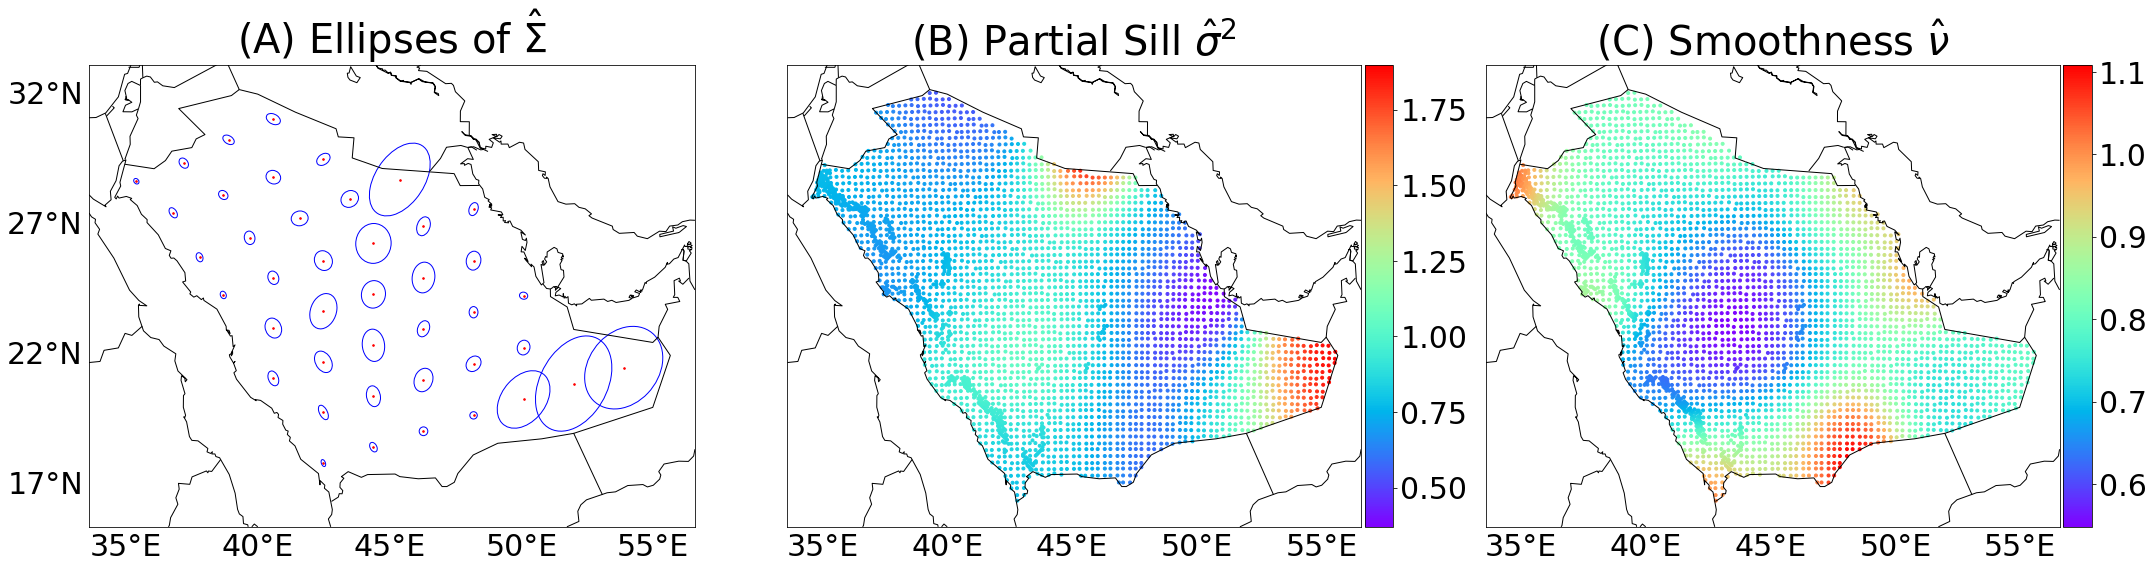

In [11]:
import utils
utils.draw_nonstationary_model("spatial/NS_model.Rdata")
plt.savefig('draw_paper_figures/ns_model.png', dpi = 150)

### Get the persistence MSE

In [12]:
per_mse_all_locations = np.zeros_like(esn_mse_all_locations).T

print('Spatial interpolating at time (total: 8760): ', end = '')
for time_id, time in enumerate(esn_model.outSampleEmb_index):

    if time_id % 100 == 0: print(time_id+1, end=' ')
        
    per_for_all_location  =  np.zeros_like(per_mse_all_locations)     
    for pred_lag in range(esn_model.numTimePred):
        per_for_all_location[pred_lag] = wind_residual_all_locations[:,time-pred_lag-1].data
    
    if time_id < 2:
        update = time_id + 1
    else:
        update = 3

    tmp = (per_for_all_location - wind_residual_all_locations[:,time])**2
    per_mse_all_locations[:update] += tmp[:update] 
    
nTest = esn_model.outSampleEmb_index.size
per_mse_all_locations = (per_mse_all_locations.T / (nTest, nTest - 1, nTest - 2))

Spatial interpolating at time (total: 8760): 1 101 201 301 401 501 601 701 801 901 1001 1101 1201 1301 1401 1501 1601 1701 1801 1901 2001 2101 2201 2301 2401 2501 2601 2701 2801 2901 3001 3101 3201 3301 3401 3501 3601 3701 3801 3901 4001 4101 4201 4301 4401 4501 4601 4701 4801 4901 5001 5101 5201 5301 5401 5501 5601 5701 5801 5901 6001 6101 6201 6301 6401 6501 6601 6701 6801 6901 7001 7101 7201 7301 7401 7501 7601 7701 7801 7901 8001 8101 8201 8301 8401 8501 8601 8701 

In [13]:
esn_mse_all = esn_mse_all_locations.mean(axis = 0)
per_mse_all = per_mse_all_locations.mean(axis = 0)

print("Part of Table 4 for the MSE for y_t at all 53,333 locations \
and time points in 2016 by the S-ESN and persistence methods. \
Note that the S-ESN is a stochastic approach, \
so the MSE may be slightly different than the values reported in the paper.\n")

print("-----------------------------------------------")
print("|     Forecast      |   S-ESN   | Persistence |")
print("-----------------------------------------------")
print("|  One hour ahead   |   {:.3f}   |    {:.3f}    |".format(esn_mse_all[0], per_mse_all[0]))
print("|  Two hours ahead  |   {:.3f}   |    {:.3f}    |".format(esn_mse_all[1], per_mse_all[1]))
print("| Three hours ahead |   {:.3f}   |    {:.3f}    |".format(esn_mse_all[2], per_mse_all[2]))
print("-----------------------------------------------")

Part of Table 4 for the MSE for y_t at all 53,333 locations and time points in 2016 by the S-ESN and persistence methods. Note that the S-ESN is a stochastic approach, so the MSE may be slightly different than the values reported in the paper.

-----------------------------------------------
|     Forecast      |   S-ESN   | Persistence |
-----------------------------------------------
|  One hour ahead   |   0.276   |    0.335    |
|  Two hours ahead  |   0.424   |    0.670    |
| Three hours ahead |   0.537   |    0.936    |
-----------------------------------------------


## Draw Figure 5, the outperformance of S-ESN to the persistence forecasts at all locations

src/utils.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


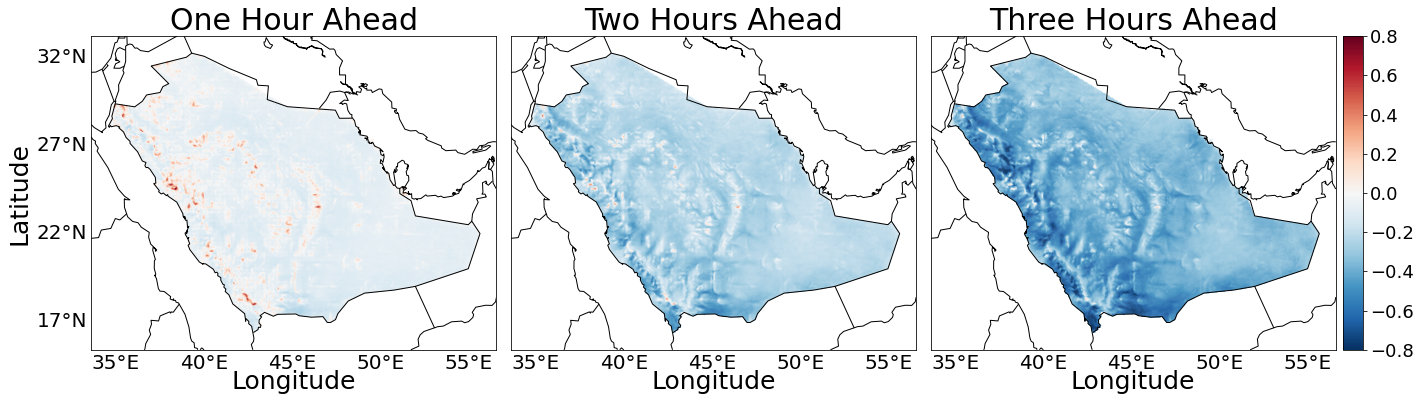

In [14]:
utils.draw_outperformance_mse_all(lon_all_locations, lat_all_locations, esn_mse_all_locations, per_mse_all_locations)
plt.savefig('draw_paper_figures/MSE_difference.png', dpi = 150)

# Get wind speed in the 75 wind farms

Load harmonic-regression related information

In [15]:
ncin = netCDF4.Dataset('./data/wind_residual_all_locations.nc', 'r', format='NETCDF4')
gamma_all_locations = ncin.variables['gamma'][:] # scaling parameter gamma(s) at all 53333 locations
harmonics_coefficients_all_locations = ncin.variables['harmonics_coefficients'][:]  # armonics_coefficients at all 53333 locations
harmonics = ncin.variables['harmonics'][:] # harmonics basis functions for each hour from 2013 to 2016
ncin.close()

Load wind farm turbine data

In [16]:
ncin = netCDF4.Dataset('./data/wind_farm_data.nc', 'r', format='NETCDF4')
alpha_turbine_location = ncin.variables['alpha_turbine_location'][:] # alpha in the wind power law for 75 wind farms at each hour of the day
index_turbine_location = ncin.variables['index_turbine_location'][:]  # index of the 75 wind farms locations in the all 53333 locations
turbine_height = ncin.variables['turbine_height'][:] # turbine heights in the 75 wind farms
turbine_type = ncin.variables['turbine_type'][:] # turbine types in the 75 wind farms
ncin.close()

index_turbine_location = index_turbine_location.astype('int')
turbine_type = turbine_type.astype('int')

Get the true wind speed at the 75 wind farms

In [17]:
harmonic_mean_turbine_locations = \
   harmonics[(nTime - 365*24):].dot(harmonics_coefficients_all_locations[index_turbine_location,1:].T)
harmonic_mean_turbine_locations += harmonics_coefficients_all_locations[index_turbine_location,0]

true_wind_speed_turbine_location = harmonic_mean_turbine_locations + \
    wind_residual_all_locations[index_turbine_location,(nTime - 365*24):].T * gamma_all_locations[index_turbine_location]
true_wind_speed_turbine_location = true_wind_speed_turbine_location.T **2

#### Run the R script to get the kriging weight for the 75 wind farms fromthe 3173 knots. 
Precomputed result, wind_farm_krig_weight.Rdata, is provided in ./spatial.

In [18]:
rerun = False

if rerun:
    os.system('Rscript spatial/get_wind_farm_krig_weight.R')

In [19]:
krig_weight = pyreadr.read_r('spatial/wind_farm_krig_weight.RDS')
krig_weight = np.array(krig_weight[None])
krig_weight = krig_weight.reshape(75, -1, order = 'F')

In [20]:
per_wind_speed_forecast_turbine_location   = wind_residual_all_locations[np.ix_(index_turbine_location, 
                                                                         esn_model.outSampleEmb_index - 2)].data
esn_wind_speed_forecast_turbine_location   = krig_weight.dot(esn_model.forMean[:,:,1].T)
df = np.load('results/arima_wind_farm_predictions.npz')
arima_wind_speed_forecast_turbine_location = df['predictions']
df.close()

esn_wind_speed_forecast_turbine_location = harmonic_mean_turbine_locations + \
    esn_wind_speed_forecast_turbine_location.T * gamma_all_locations[index_turbine_location]
esn_wind_speed_forecast_turbine_location = esn_wind_speed_forecast_turbine_location.T **2

per_wind_speed_forecast_turbine_location = harmonic_mean_turbine_locations + \
    per_wind_speed_forecast_turbine_location.T * gamma_all_locations[index_turbine_location]
per_wind_speed_forecast_turbine_location = per_wind_speed_forecast_turbine_location.T **2

arima_wind_speed_forecast_turbine_location = harmonic_mean_turbine_locations + \
    arima_wind_speed_forecast_turbine_location.T * gamma_all_locations[index_turbine_location]
arima_wind_speed_forecast_turbine_location = arima_wind_speed_forecast_turbine_location.T **2

# Transform to wind power

Set up manufacturer power curve

In [21]:
# power_curve: power generated in the two wind turbine models
winds_peed = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5,15,15.5,16,16.5,17,17.5,18,18.5,19,19.5,20,20.5,21,21.5,22,22.5,23,23.5,24,24.5,25,25.5,26,26.5,27,27.5,28,28.5,29,29.5,
                      30,30.5,31,31.5,32,32.5,33,33.5,34,34.5,35,35.5,36,36.5,37])

power_curve = np.array([[0,0,0,0,0,0,33,106,197,311,447,610,804,1032,1298,1601,1936,2292,2635,2901,3091,3215,3281,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,3300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                       [0,0,0,0,0,0,29,68,114,177,243,347,452,595,738,907,1076,1307,1538,1786,2033,2219,2405,2535,2633,2710,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,2750,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])


def get_power_curve(t_m,x):
    if x > 37:
        return 0
    left_ind = int(x*2)
    power = (power_curve[t_m,left_ind+1]-power_curve[t_m,left_ind]) * (x-winds_peed[left_ind])/0.5 +\
        power_curve[t_m,left_ind]
    return(power)

Get the true wind power

In [22]:
true_power_turbine_height = np.empty(true_wind_speed_turbine_location.shape) * np.nan

for loc in np.arange(75):
    for time in np.arange(1,8760):
        tmp =  true_wind_speed_turbine_location[loc,time] * \
            (turbine_height[loc]/10)**alpha_turbine_location[loc,time%24]
        true_power_turbine_height[loc,time] = get_power_curve(turbine_type[loc],tmp) 

Get the wind power forecast by the persistence and S-ESN

In [23]:
esn_power_turbine_height   = np.empty((75,8760)) * np.nan 
per_power_turbine_height   = np.empty((75,8760)) * np.nan 
arima_power_turbine_height = np.empty((75,8760)) * np.nan 


for loc in np.arange(75):
    for time in np.arange(1,8760):
        tmp = esn_wind_speed_forecast_turbine_location[loc,time] * \
            (turbine_height[loc]/10)**alpha_turbine_location[loc,time%24]
        esn_power_turbine_height[loc,time] = get_power_curve(turbine_type[loc],tmp) 
                
        tmp = per_wind_speed_forecast_turbine_location[loc,time] * \
            (turbine_height[loc]/10)**alpha_turbine_location[loc,time%24]
        per_power_turbine_height[loc,time] = get_power_curve(turbine_type[loc],tmp) 
        
        tmp = arima_wind_speed_forecast_turbine_location[loc,time] * \
            (turbine_height[loc]/10)**alpha_turbine_location[loc,time%24]
        arima_power_turbine_height[loc,time] = get_power_curve(turbine_type[loc],tmp) 

Calculate the whole-year difference in wind energy at wind farms

In [24]:
esn_wind_energy_diff   = np.nansum(np.abs(esn_power_turbine_height - true_power_turbine_height))
per_wind_energy_diff   = np.nansum(np.abs(per_power_turbine_height - true_power_turbine_height))
arima_wind_energy_diff = np.nansum(np.abs(arima_power_turbine_height - true_power_turbine_height))
print('The annual sum of the absolute differences in wind energy during 2016 at all the 75 wind turbines is\n\
      {:.2E}kW·h for S-ESN,\n\
      {:.2E}kW·h for ARIMA,\n\
  and {:.2E}kW·h for persistence.\n\
Thus, we obtain a {:.0f}% improvement against the ARIMA forecasts \
and an {:.0f}% improvement against the persistence forecasts.'.\
    format(esn_wind_energy_diff, arima_wind_energy_diff, per_wind_energy_diff,
           (arima_wind_energy_diff-esn_wind_energy_diff)/arima_wind_energy_diff*100,
           (per_wind_energy_diff-esn_wind_energy_diff)/per_wind_energy_diff*100))

The annual sum of the absolute differences in wind energy during 2016 at all the 75 wind turbines is
      2.77E+08kW·h for S-ESN,
      3.05E+08kW·h for ARIMA,
  and 3.12E+08kW·h for persistence.
Thus, we obtain a 9% improvement against the ARIMA forecasts and an 11% improvement against the persistence forecasts.


# Obtain the probabilistic forecasts
### Calibrate prediction distribution at 3173 knots
1. Model is trained using data from 2013 to 2014 at 3173 knots
2. Wind speed residual at 3173 knots in 2015 is forecasted
3. Prediction distribution is calibrated via the quantiles between the truth and the ensemble mean in 2015 at 3173 knots

Set rerun_calibration = True to re-run the calibration, which uses 100 ensemble members to get the quantile and takes some time. Otherwise, the precomputed result is used

In [25]:
rerun_calibration = False

quantile = np.arange(0.025,1,0.025)

if rerun:
    from estimate_distribution import estimate_distribution
    forErrorQuantile, forMean2015 = estimate_distribution(data,index,hyperpara)
    np.savez(file = 'results/quantiles_knots.npz', forErrorQuantile = forErrorQuantile)
else:
    file = np.load('results/quantiles_knots.npz')
    forErrorQuantile = file['forErrorQuantile']

### Show prediction interval coverage for 2016 at 3173 knots

In [26]:
lower_ind = np.empty(3).astype('int')
upper_ind = np.empty(3).astype('int')

# 95%
lower_ind[0] = np.where( np.abs(quantile - 0.025) < 1e-12 ) [0][0]
upper_ind[0] = np.where( np.abs(quantile - 0.975) < 1e-12 )[0][0]

# 80%
lower_ind[1] = np.where( np.abs(quantile - 0.1) < 1e-12 ) [0][0]
upper_ind[1] = np.where( np.abs(quantile - 0.9) < 1e-12 )[0][0]

# 60%
lower_ind[2] = np.where( np.abs(quantile - 0.2) < 1e-12 ) [0][0]
upper_ind[2] = np.where( np.abs(quantile - 0.8) < 1e-12 )[0][0]

PI = np.empty((3,3,3173))
    
for i in range(3):
    LB = esn_model.forMean + forErrorQuantile[lower_ind[i]]
    UB = esn_model.forMean + forErrorQuantile[upper_ind[i]]

    for j in range(3):
        PI[i,j] = (np.logical_and(
                                esn_model.data.ts[esn_model.outSampleEmb_index] < UB[:,:,j], 
                                esn_model.data.ts[esn_model.outSampleEmb_index] > LB[:,:,j])
                  ).sum(axis = 0) / (~np.isnan(UB[:,:,j])).sum(axis = 0)

PI_mean = np.mean(PI, axis = 2)
PI_std = np.std(PI, axis = 2)

In [27]:
print("Table 2 for the mean prediction interval coverage of y_t^* at all 3,173 knots \
and time points in 2016 by the ESN (standard deviation across knots is shown in parentheses). \
Note that the ESN is a stochastic approach, \
so the values may be slightly different than the values reported in the paper.\n")

print("--------------------------------------------------------------")
print("| Prediction |         Prediction Interval Coverage          |")
print("|  Interval  |    1h ahead    |    2h ahead   |   3h ahead   |")  
print("--------------------------------------------------------------")
print("|     95%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_mean[0,0], PI_std[0,0], PI_mean[0,1], PI_std[0,1], PI_mean[0,2], PI_std[0,2]))
print("--------------------------------------------------------------")
print("|     80%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_mean[1,0], PI_std[1,0], PI_mean[1,1], PI_std[1,1], PI_mean[1,2], PI_std[1,2]))
print("--------------------------------------------------------------")
print("|     60%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_mean[2,0], PI_std[2,0], PI_mean[2,1], PI_std[2,1], PI_mean[2,2], PI_std[2,2]))
print("--------------------------------------------------------------")

Table 2 for the mean prediction interval coverage of y_t^* at all 3,173 knots and time points in 2016 by the ESN (standard deviation across knots is shown in parentheses). Note that the ESN is a stochastic approach, so the values may be slightly different than the values reported in the paper.

--------------------------------------------------------------
| Prediction |         Prediction Interval Coverage          |
|  Interval  |    1h ahead    |    2h ahead   |   3h ahead   |
--------------------------------------------------------------
|     95%    |   94.8%(0.5%)  |  94.6%(0.6%)  |  94.6%(0.7%) |
--------------------------------------------------------------
|     80%    |   80.7%(1.0%)  |  80.6%(1.1%)  |  80.6%(1.2%) |
--------------------------------------------------------------
|     60%    |   60.7%(1.3%)  |  60.3%(1.3%)  |  60.1%(1.5%) |
--------------------------------------------------------------


### Calibrate prediction distribution via the quantiles between the truth and the ensemble mean in 2015 at all locations

In [28]:
rerun_calibration = False

if rerun_calibration:
    try:
        krig_weight_all
    except NameError:
        os.system('Rscript spatial/get_all_krig_weight.R')
        krig_weight_all = pyreadr.read_r('spatial/all_krig_weight.RDS')
        krig_weight_all = np.array(krig_weight_all[None])
        krig_weight_all = krig_weight_all.reshape(53333, -1, order = 'F')

    try:
        forMean2015
    except NameError:
        _, forMean2015 = estimate_distribution(data,index,hyperpara)

    forMean2015_all = krig_weight_all.dot(forMean2015)

    forError2015_all = np.zeros_like(forMean2015_all)
    for ahead in range(3):
        forError2015_all[:,:,ahead] = forMean2015_all[:,:,ahead] - \
            wind_residual_all_locations[:,(data.nTime - 365*24*2):(data.nTime - 365*24)]

    forErrorQuantile_all = np.ndarray((quantile.size, forError2015_all.shape[0], 3))
    for i in range(quantile.size):
        forErrorQuantile_all[i] = np.nanquantile(forError2015_all, quantile[i], axis = 1)
    np.savez(file = 'results/quantiles_all.npz', forErrorQuantile_all = forErrorQuantile_all)
else:
    df = np.load('results/quantiles_all.npz')
    forErrorQuantile_all = df['forErrorQuantile_all']
    df.close()

### Show prediction interval coverage for 2016 at all 53333 knots

In [29]:
try:
    forMean2016_all
except NameError:
    try:
        krig_weight_all
    except NameError:
        os.system('Rscript spatial/get_all_krig_weight.R')
        krig_weight_all = pyreadr.read_r('spatial/all_krig_weight.RDS')
        krig_weight_all = np.array(krig_weight_all[None])
        krig_weight_all = krig_weight_all.reshape(53333, -1, order = 'F')

    forMean2016_all = krig_weight_all.dot(esn_model.forMean)

In [30]:
forecast = np.swapaxes(forMean2016_all,0,1)
true = wind_residual_all_locations[:,esn_model.outSampleEmb_index].T
PI_all = np.empty((3,3,53333))

for i in range(3):
    LB = forecast + forErrorQuantile_all[lower_ind[i]]
    UB = forecast + forErrorQuantile_all[upper_ind[i]]

    for j in range(3):
        PI_all[i,j] = (np.logical_and(true < UB[:,:,j], 
                                      true > LB[:,:,j])
                      ).sum(axis = 0) / (~np.isnan(UB[:,:,j])).sum(axis = 0)

PI_all_mean = np.mean(PI_all, axis = 2)
PI_all_std = np.std(PI_all, axis = 2)

In [31]:
print("Table S2 for the mean prediction interval coverage of y_t at all 53,333 locations \
and time points in 2016 using the ESN (standard deviation across knots is shown in parentheses). \
Note that the ESN is a stochastic approach, \
so the values may be slightly different than the values reported in the paper.\n")

print("--------------------------------------------------------------")
print("| Prediction |         Prediction Interval Coverage          |")
print("|  Interval  |    1h ahead    |    2h ahead   |   3h ahead   |")  
print("--------------------------------------------------------------")
print("|     95%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_all_mean[0,0], PI_all_std[0,0], PI_all_mean[0,1], PI_all_std[0,1], PI_all_mean[0,2], PI_all_std[0,2]))
print("--------------------------------------------------------------")
print("|     80%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_all_mean[1,0], PI_all_std[1,0], PI_all_mean[1,1], PI_all_std[1,1], PI_all_mean[1,2], PI_all_std[1,2]))
print("--------------------------------------------------------------")
print("|     60%    |   {:.1%}({:.1%})  |  {:.1%}({:.1%})  |  {:.1%}({:.1%}) |".
      format(PI_all_mean[2,0], PI_all_std[2,0], PI_all_mean[2,1], PI_all_std[2,1], PI_all_mean[2,2], PI_all_std[2,2]))
print("--------------------------------------------------------------")

Table S2 for the mean prediction interval coverage of y_t at all 53,333 locations and time points in 2016 using the ESN (standard deviation across knots is shown in parentheses). Note that the ESN is a stochastic approach, so the values may be slightly different than the values reported in the paper.

--------------------------------------------------------------
| Prediction |         Prediction Interval Coverage          |
|  Interval  |    1h ahead    |    2h ahead   |   3h ahead   |
--------------------------------------------------------------
|     95%    |   94.6%(0.7%)  |  94.5%(0.7%)  |  94.5%(0.7%) |
--------------------------------------------------------------
|     80%    |   80.5%(1.1%)  |  80.6%(1.1%)  |  80.6%(1.2%) |
--------------------------------------------------------------
|     60%    |   60.1%(1.5%)  |  60.1%(1.4%)  |  60.0%(1.5%) |
--------------------------------------------------------------


### Prediction Quantiles for the forecasted generated power at the 75 wind farms

<span style="color:red"> Due to the storage limit in Github, the precomputed results cannot be uploaded. The variable rerun must be True for the first time. Computing the probabilistic forecasts for generated power should finish less than half an hour.</span>

In [32]:
rerun = False

if rerun:
    esn_turbine_location = krig_weight.dot(esn_model.forMean[:,:,1].T).T
    esn_turbine_location_quantile = np.empty((quantile.size, *esn_turbine_location.shape))

    for i in range(quantile.size):
        esn_turbine_location_quantile[i] = esn_turbine_location + forErrorQuantile_all[i,index_turbine_location,1]

    esn_wind_speed_turbine_location_quantile = harmonic_mean_turbine_locations + \
        esn_turbine_location_quantile * gamma_all_locations[index_turbine_location]
    esn_wind_speed_turbine_location_quantile = esn_wind_speed_turbine_location_quantile ** 2

    esn_power_turbine_height_quantile   = np.zeros_like(esn_wind_speed_turbine_location_quantile)

    for i in range(quantile.size):
        for loc in range(75):
            for time in np.arange(1,8760):
                tmp = esn_wind_speed_turbine_location_quantile[i,time,loc] * \
                    (turbine_height[loc]/10)**alpha_turbine_location[loc,time%24]
                esn_power_turbine_height_quantile[i,time,loc] = get_power_curve(turbine_type[loc],tmp) 

    esn_total_power_turbine_height_quantile_diff = \
        np.nansum(np.abs(esn_power_turbine_height_quantile - true_power_turbine_height.T), axis = (1,2))
    np.savez(file = 'results/power_quantiles.npz', esn_power_turbine_height_quantile = esn_power_turbine_height_quantile)
else:
    df = np.load('results/power_quantiles.npz')
    esn_power_turbine_height_quantile = df['esn_power_turbine_height_quantile']
    df.close()
    esn_total_power_turbine_height_quantile_diff = \
        np.nansum(np.abs(esn_power_turbine_height_quantile - true_power_turbine_height.T), axis = (1,2))    

### Draw Figure 5, the annual sum of the absolute differences between the S-ESN forecast quantiles and the truth in wind energy during 2016 at all the 75 wind turbines combined

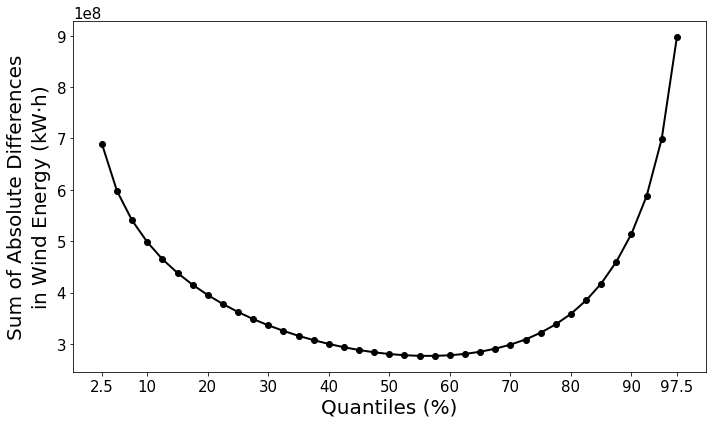

In [33]:
utils.draw_power_quantile(quantile, esn_total_power_turbine_height_quantile_diff)
plt.savefig('draw_paper_figures/power_quantile.pdf')